## EC Lab 2
### Summary
The aim of lab is to learn a reinforcement learning agent to play simple GYM environment (LunarLander-v2). The agent is a neural network that takes as input current state of a game and outputs probabilities for actions. (https://gym.openai.com/).

You have a pattern script with main structure of algorithm, but you have to repair it or change it completely, as you wish. You can change current mutation, crossover, selection, evolution scheme or even use another algorithm as PSO.  To use LunarLander, you need to uncomment config for it, because by default it is stand for CartPole environment.

As for LunarLander, the agent receives following rewards: -0.1 for each time you launch the engine, -100 for broke and +200 for successful landing. Therefore, good results starts from +100 approximately.

Please, work with this script and try to learn the agent how to play and achieve good scores. Lets say about restriction:
max_pop_size = 20;
maximum_iterations = 200.

Prepare IPython Notebook with all your things there (maybe some good analysis, and ideas). Send me only IPython file topic ec_lab2_surname on mihail.melnik.ifmo@gmail.com.

In [ ]:
# Imports
from deap import tools, base, creator
import numpy as np
from function_opt.ga_scheme import eaMuPlusLambda
import numpy.random as rnd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer
import gym
from function_opt.draw_log import draw_log
from copy import deepcopy

creator.create("BaseFitness", base.Fitness, weights=(1.0, ))
creator.create("Individual", list, fitness=creator.BaseFitness)

In [ ]:
class RL_ga_experiment:
    def factory(self):
        individual = list()
        for i in range(len(self.params)):
            if i % 2 == 0:
                individual.append(rnd.normal(0.1, 0.3, size=self.params[i].shape))
            else:
                individual.append(np.zeros(shape=self.params[i].shape))
        return creator.Individual(individual)

    def mutation(self, individual):
        for i in range(len(individual)):
            if i % 2 == 0:
                for j in range(len(individual[i])):
                    for k in range(len(individual[i][j])):
                        if rnd.random() < 0.15:
                            individual[i][j] += rnd.normal(0.0, 0.2)

        return individual,


    def crossover(self, p1, p2):

        c1 = list()
        c2 = list()

        c1.append(deepcopy(p1[0]))
        c1.append(deepcopy(p1[1])) # zero
        c1.append(deepcopy(p2[2]))
        c1.append(deepcopy(p1[3])) # zero
        c1.append(deepcopy(p1[4]))
        c1.append(deepcopy(p1[5])) # zero

        c2.append(deepcopy(p2[0]))
        c2.append(deepcopy(p2[1]))  # zero
        c2.append(deepcopy(p1[2]))
        c2.append(deepcopy(p2[3]))  # zero
        c2.append(deepcopy(p2[4]))
        c2.append(deepcopy(p2[5]))  # zero

        return creator.Individual(c1), creator.Individual(c2)

    def __init__(self, input_dim, l1, l2, output_dim, pop_size, iterations):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.l1 = l1
        self.l2 = l2
        self.pop_size = pop_size
        self.iterations = iterations

        self.model = self.build_model()
        self.params = self.model.get_weights()

        #self.env = gym.make("CartPole-v0")
        # todo uncomment for LunarLander
        self.env = gym.make("LunarLander-v2")

        self.engine = base.Toolbox()
        self.engine.register('map', map)
        self.engine.register("individual", tools.initIterate, creator.Individual, self.factory)
        self.engine.register('population', tools.initRepeat, list, self.engine.individual, self.pop_size)
        self.engine.register('mutate', self.mutation)
        self.engine.register("mate", self.crossover)
        self.engine.register('select', tools.selTournament, tournsize=3)
        self.engine.register('evaluate', self.fitness)
        self.render = False

    def compare(self, ind1, ind2):
        result = True
        for i in range(len(ind1)):
            if i % 2 == 0:
                for j in range(len(ind1[i])):
                    for k in range(len(ind1[i][j])):
                        if ind1[i][j][k] != ind2[i][j][k]:
                            return False

        return result

    def run(self):
        pop = self.engine.population()
        hof = tools.HallOfFame(3, similar=self.compare)
        stats = tools.Statistics(lambda ind: ind.fitness.values[0])
        stats.register('min', np.min)
        stats.register('max', np.max)
        stats.register('avg', np.mean)
        stats.register('std', np.std)

        pop, log = eaMuPlusLambda(pop, self.engine, mu=self.pop_size, lambda_=int(0.8 * self.pop_size), cxpb=0.4, mutpb=0.4,
                                  ngen=self.iterations, verbose=True, halloffame=hof, stats=stats)
        best = hof[0]
        print("Best fitness = {}".format(best.fitness.values[0]))
        return log, best


    def build_model(self):
        model = Sequential()
        model.add(InputLayer(self.input_dim))
        model.add(Dense(self.l1, activation='relu'))
        model.add(Dense(self.l2, activation='relu'))
        model.add(Dense(self.output_dim, activation='softmax'))
        model.compile(optimizer='adam', loss='mse')
        return model

    def fitness(self, individual):
        self.model.set_weights(individual)
        scores = []
        for _ in range(1):
            state = self.env.reset()
            score = 0.0
            for t in range(200):
                if self.render:
                    self.env.render()
                act_prob = self.model.predict(state.reshape(1, self.input_dim)).squeeze()
                action = rnd.choice(np.arange(self.output_dim), 1, p=act_prob)[0]
                next_state, reward, done, _ = self.env.step(action)
                score += reward
                state = next_state
                if done:
                    break
            scores.append(score)
        return np.mean(scores),


gen	nevals	min     	max     	avg     	std    
0  	10    	-813.331	-53.3992	-322.429	202.988
1  	7     	-170.097	-53.3992	-103.564	43.6801
2  	6     	-118.909	-53.3992	-80.2579	28.1281
3  	8     	-110.778	-53.3992	-71.0633	23.1931
4  	8     	-135.128	-53.3992	-70.8547	25.5048
5  	7     	-135.128	-53.3992	-70.8547	25.5048
6  	7     	-84.3413	-53.3992	-65.776 	15.1585
7  	8     	-84.3413	-53.3992	-56.4934	9.28266
8  	8     	-121.916	-53.3992	-62.5454	20.9392
9  	7     	-317.632	-53.3992	-82.117 	78.8026
10 	7     	-53.3992	-53.3992	-53.3992	0      
Best fitness = -53.39916168037189


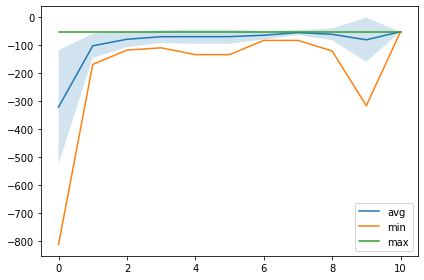

In [4]:
if __name__ == '__main__':
    # config for CartPole
    # input_dim = 4
    # l1 = 20
    # l2 = 12
    # output_dim = 2

    # todo config for Lunar Lander
    input_dim = 8
    l1 = 64
    l2 = 16
    output_dim = 4

    pop_size = 10
    iterations = 10

    exp = RL_ga_experiment(input_dim, l1, l2, output_dim, pop_size, iterations)
    exp.render = False
    log, best = exp.run()

    draw_log(log)
    exp.render = True
    for _ in range(100):
        exp.fitness(best)